# Social Graphs Project

## Pre-processing

### Imports

In [86]:
import pandas as pd
import numpy as np
import re
import urllib.request
import json
import os
import string  
import math
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import seaborn as sns
import networkx as nx
import community
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator
from fa2 import ForceAtlas2
from PIL import Image, ImageFont

### Extract wiki data

### Data cleaning

In [87]:
df = pd.read_csv('data/git_data_third.csv',index_col=0)
df['languages'] = df['languages'].str.replace(' ',',').str.replace('\n','').str.replace("'","")
df['out'] = df['out'].str.replace(' ',',').str.replace('\n','').str.replace("'","")
df.head(3)

,user_name,owner,repos,name,type,company,location,bio,created_at,updated_at,following,description,languages,out,in_degree,out_degree,connections
0,josephmisiti,josephmisiti,awesome-machine-learning,Joseph Misiti,User,Math & Pencil,"Brooklyn, NY",Mathematician & Co-founder of Math & Pencil,2010-04-17T21:09:13Z,2020-10-29T18:11:39Z,"['mojombo', 'defunkt', 'vanpelt', 'macournoyer...",SDK and example code for building voice-enabl...,"[C,C++,CSS,Go,Java,JavaScript,Jupyter,Notebook...","[JWarmenhoven,agramfort,alextp,amueller,bamos,...",14,17,31
1,wepe,wepe,MachineLearning,wepon,User,AntFin,China Hangzhou,NaN,2014-10-10T14:28:18Z,2020-11-05T15:54:10Z,"['pluskid', 'benanne', 'colah', 'kennethreitz4...",1st Place Season one & 6th Place Season two1st...,"[C++,HTML,Java,Python,Shell]","[aymericdamien,enjoyhot,guolinke,junlulocky]",11,4,15
2,ZuzooVn,ZuzooVn,machine-learning-for-software-engineers,Nam Vu,User,NaN,Vietnam,A Vietnamese Software Engineer who is really p...,2012-02-11T16:55:02Z,2020-10-12T02:40:45Z,"['ole', 'escoz', 'pokeb', 'tcdoan', 'dyang', '...",Android executables browserEasy to use CFNetwo...,"[C,DIGITAL,Command,Language,HTML,Java,JavaScri...",[jwasham],6,1,7


In [88]:
def stringToList(colname):
    df[colname] = [df[colname][i][1:len(df[colname][i])-1].split(',') for i in range(len(df))]

stringToList('out')
stringToList('following')
stringToList('languages')

## Generate network

In [89]:
# store the network of users with DiGraph
G = nx.DiGraph()
G.add_nodes_from(df['user_name'].values)

for row in df.iterrows():
    z = [(row[1]['user_name'], other_node) for other_node in row[1]['out']]
    G.add_edges_from(z)

# extract giant connected component 
largest_cc = max(nx.weakly_connected_components(G), key=len)
GCC = G.subgraph(largest_cc)

## Network statistics

In [90]:
print(f"Number of nodes in GCC: {GCC.number_of_nodes()}")
print(f"Number of edges in GCC: {GCC.number_of_edges()}")

Number of nodes in GCC: 738
Number of edges in GCC: 2301


In [91]:
# find highest in-degree nodes
print('Top 5 in-degree users')
display(df.sort_values(by=['in_degree'], ascending=False)[['user_name','in_degree']].head())

# find highest out-degree nodes
print('Top 5 out-degree characters ')
display(df.sort_values(by=['out_degree'], ascending=False)[['user_name','out_degree']].head())

# find highest in and out degree nodes
df['connections'] = df['in_degree']+df['out_degree']
print('Top 5 connected users')
display(df.sort_values(by=['connections'], ascending=False)[['user_name','in_degree','out_degree','connections']].head())

Top 5 in-degree users


,user_name,in_degree
178,amueller,67
214,ogrisel,63
275,fchollet,58
22,llSourcell,56
3,rasbt,55


Top 5 out-degree characters 


,user_name,out_degree
575,yupbank,68
276,feihugis,43
540,gaocegege,42
623,silverstone1903,41
493,justinormont,36


Top 5 connected users


,user_name,in_degree,out_degree,connections
178,amueller,67,16,83
214,ogrisel,63,19,82
575,yupbank,4,68,72
91,soumith,52,12,64
3,rasbt,55,5,60


### Node degree distribution

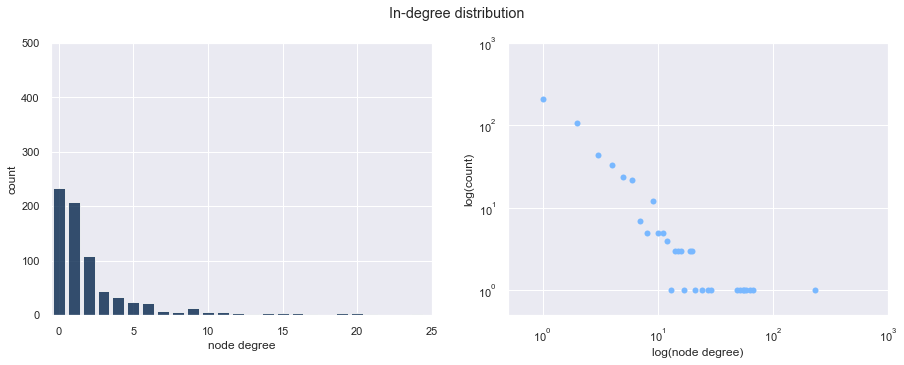

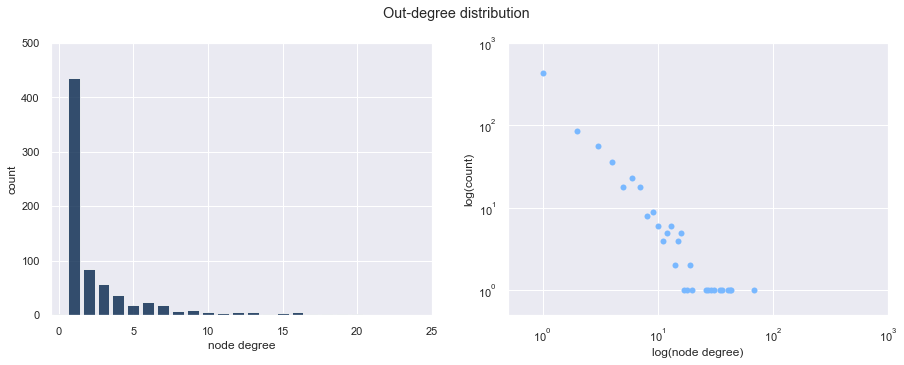

In [92]:
def degree_distribution(G, mode):
    
    # find in or out degrees of network
    if mode.lower() == 'in':
        degree_sequence = [d for n, d in G.in_degree()]
    else:
        degree_sequence = [d for n, d in G.out_degree()]
    # find min and max of degrees     
    dmax = max(degree_sequence)
    dmin = min(degree_sequence)
    
    # compute frequencies of degrees distribution
    counts, bins = np.histogram(degree_sequence, bins = np.arange(dmin-0.5, dmax+1.5,1))
    
    sns.set()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [15,5])
    fig.suptitle(mode+'-degree distribution')
    
    # plot histogram 
    ax1.bar(np.arange(dmin, dmax+1,1), counts, color=blue[4], alpha=0.8)
    ax1.set_xlim(-0.5, 25)
    ax1.set_ylim(0, 500)
    ax1.set_xlabel('node degree')
    ax1.set_ylabel('count')
    
    # plot scatter plot on log-log scale
    ax2.loglog(np.arange(dmin, dmax+1,1), counts, 'o', color=blue[1])
    ax2.set_xlim(0.5, 10**3)
    ax2.set_ylim(0.5, 10**3)
    ax2.set_xlabel('log(node degree)')
    ax2.set_ylabel('log(count)')
    plt.show()
    
degree_distribution(GCC,'In')
degree_distribution(GCC,'Out')

## Visualization

### Network visualization

In [93]:
# Convert to undirected graph
giant = GCC.to_undirected()

# Scale node-size according to degree
d = dict(giant.degree)
sizes = [v * 7 for v in d.values()]

# color
blue = ['#c8e1ff','#79b8ff','#0366d6','#044289','#05264c']

# Specify settings for the Force Atlas 2 algorithm
forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True, # Dissuade hubs
    linLogMode=False,  
    adjustSizes=False,
    edgeWeightInfluence=1.0,

    # Performance
    jitterTolerance=1.0,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,  

    # Tuning
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=1.0,

    # Log
    verbose=True)

# Get positions based on theForce Atlas 2 algorithm
positions = forceatlas2.forceatlas2_networkx_layout(giant, pos=None, iterations=2000)

100%|██████████| 2000/2000 [00:09<00:00, 207.45it/s]

BarnesHut Approximation  took  2.55  seconds
Repulsion forces  took  6.37  seconds
Gravitational forces  took  0.07  seconds
Attraction forces  took  0.05  seconds
AdjustSpeedAndApplyForces step  took  0.27  seconds


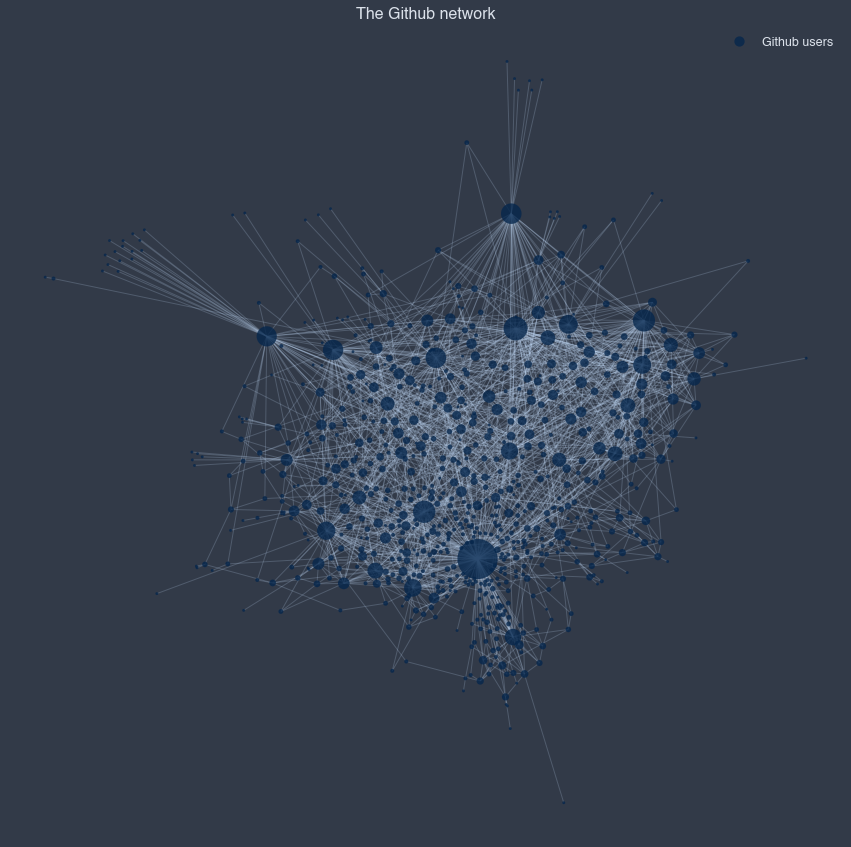

In [94]:
# Set style and figure size
jtplot.style('chesterish')
fig = plt.figure(figsize=(15,15))

# Draw network
nx.draw_networkx_nodes(giant, positions, node_color=blue[4], alpha=0.8, node_size=sizes)
nx.draw_networkx_edges(giant, positions, edge_color=blue[0], alpha=0.2)
 
# Create legend, remove axes and set title
plt.scatter([], [], c=blue[4], alpha=0.8, s=100, label='Github users')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1)
plt.title('The Github network', fontsize=16)
plt.axis('off')

plt.show()
fig.savefig('githubnetwork.png', facecolor=fig.get_facecolor(), transparent=True)